In [22]:
import scipy
import bagpy
import numpy as np
from bagpy import bagreader
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
from matplotlib import rc
import statistics
import regex as re
rc('text', usetex=False) 
plt.rcParams['text.usetex'] = False

### Plotting methods for the Fundamentals of Robotics Course

In [23]:
def get_topics(b):
    csv_files = []
    for topic in b.topics:
        #print(topic)
        data = b.message_by_topic(topic)
        csv_files.append(data)
    return csv_files

bag = "./recorded_data.bag"
b = bagreader(bag)
csv_files = get_topics(b)
print(csv_files)
current_pose = pd.read_csv(csv_files[0])
joint_states = pd.read_csv(csv_files[2])
ho_cook_joint_states = pd.read_csv(csv_files[1])
p2p_joint_states = pd.read_csv(csv_files[3])
joint_trajectory = pd.read_csv(csv_files[-1])

def parse_timeseries_string(string_data):
    # Define regular expressions for extracting positions and velocities
    positions_pattern = re.compile(r'positions: \[([^\]]+)\]')
    velocities_pattern = re.compile(r'velocities: \[([^\]]+)\]')
    time_pattern = re.compile(r'time_from_start: \n\s*secs: (\d+)\n\s*nsecs: (\d+)')

    # Extract data using regular expressions
    positions_match = positions_pattern.findall(string_data)
    velocities_match = velocities_pattern.findall(string_data)
    time_match = time_pattern.findall(string_data)

    # Initialize lists for positions and velocities
    positions_list = []
    velocities_list = []
    times_list = []

    # Extract positions
    for positions_str in positions_match:
        positions_list.append([float(pos) for pos in positions_str.split(',')])

    # Extract velocities (assuming an empty list if not found)
    for velocities_str in velocities_match:
        velocities_list.append([float(vel) for vel in velocities_str.split(',')])
        
    # Extract time_from_start
    for secs, nsecs in time_match:
        time_in_seconds = int(secs) + int(nsecs) / 1e9
        times_list.append(time_in_seconds)

    return positions_list, velocities_list, times_list

def parse_joint_states(joint_states): 
    
    n_joints = len(joint_states["name"][0].split(","))
    q = {}
    q["t"] = joint_states["Time"]
    print(n_joints)
    for i in range(0, n_joints): 
        q["p{}".format(i)] = joint_states["position_{}".format(i)]
        q["v{}".format(i)] = joint_states["velocity_{}".format(i)]
    return q

# Commanded points for HoCook 
def parse_trajectory(trajectory): 
    p, v, t = parse_timeseries_string(trajectory) 
    return p, v, t

def plot_joint_states(positions, velocities, times):
    # Plot Joint Positions
    plt.figure(figsize=(12, 6))
    for i in range(len(positions[0])):
        plt.plot(times, [pos[i] for pos in positions], label=f'q{i}')

    plt.title('Joint Positions Over Time')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Joint Positions')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Joint Velocities
    plt.figure(figsize=(12, 6))
    for i in range(len(velocities[0])):
        plt.plot(times, [vel[i] for vel in velocities], label=f'v{i}')

    plt.title('Joint Velocities Over Time')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Joint Velocities')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    
def plot_pva(positions, velocities, times):
    # Plot Joint Positions
    
    fig, ax = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
    
    for i in range(len(positions[0])):
        ax[0].plot(times, [pos[i] for pos in positions], label=f'q{i}')
    ax[0].legend()
    ax[0].set_title('Position')
    ax[0].set_ylabel('q[t]')
    ax[0].grid()

    # Plot Joint Velocities
    for i in range(len(velocities[0])):
        ax[1].plot(times, [vel[i] for vel in velocities], label=f'v{i}')
    ax[1].legend()
    ax[1].set_title('Velocity')
    ax[1].set_ylabel('v[t]')
    ax[1].grid('both')

    # Calculate accelerations
    a = np.gradient(np.array(t['v']))
    # Plot Joint Accelerations
    plt.figure(figsize=(12, 6))
    for i in range(7):
        ax[2].plot(times, a[0][:, i], label=f'a{i}')
         
    ax[2].legend()
    ax[2].set_title('Acceleration')
    ax[2].set_ylabel('a[t]')
    ax[2].set_xlabel('t[s]')
    ax[2].set_xlim([0, max(times)])
    ax[2].grid('both')
    plt.savefig("orlab3_trajectories.png")

def plot_3d(x, y, z):

    # Create a 3D plot
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the robot manipulator movement
    ax.plot(x, y, z, label='End effector position')

    # Set labels for the axes
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')

    # Set a title for the plot
    ax.set_title('End effector position')

    # Add a legend
    ax.legend()

    # Show the plot
    plt.show()
    plt.savefig('hocook_3d.png')
    
def plot_qs(p2p, hocook): 
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 8), sharey=True)
    t1 = np.linspace(0, max(p2p['t']), len(p2p['p0']))
    t2 = np.linspace(0, max(hocook['t']), len(hocook['p0']))
    for i in range(7):
        ax[0].plot(t1, p2p[f'p{i}'], label=f'q{i}')
        ax[0].grid()
        ax[0].set_xlabel('t [s]')
        ax[0].set_ylabel('q [rad]')
        ax[0].set_xlim(0, max(p2p['t']))
        ax[0].legend()
        ax[0].set_title("Point to point movement")
    
    for i in range(7): 
        ax[1].plot(t2, hocook[f'p{i}'], label=f'q{i}')
        ax[1].grid()
        ax[1].set_xlabel('t [s]')
        ax[1].set_ylabel('q [rad]')
        ax[1].set_xlim(0, max(hocook['t']))
        ax[1].legend()
        ax[1].set_title('Hocook movement')
    
    plt.savefig('joint_states_comparison.png')


[INFO]  Data folder ./recorded_data already exists. Not creating.
['./recorded_data/control_arm_node-tool-current_pose.csv', './recorded_data/hocook-joint_states.csv', './recorded_data/joint_states.csv', './recorded_data/p2p-joint_states.csv', './recorded_data/position_joint_trajectory_controller-command.csv']


7
7
Trajectory 7: 371


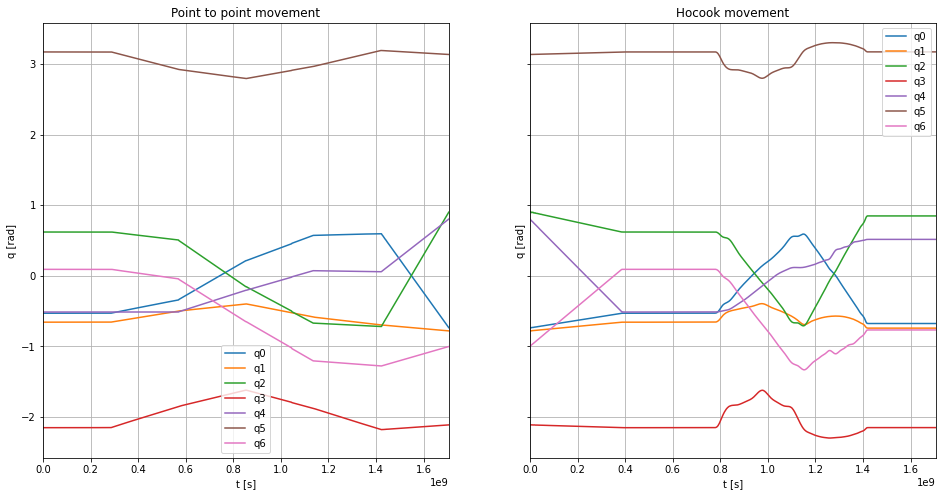

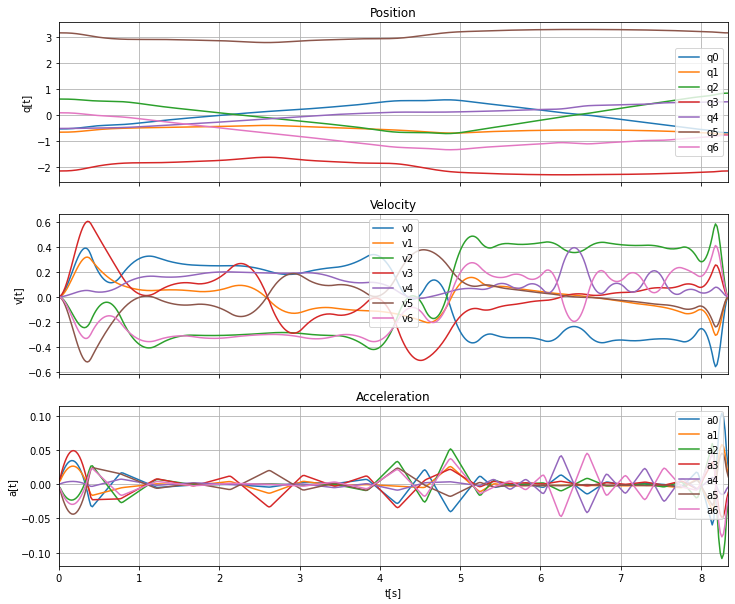

<Figure size 864x432 with 0 Axes>

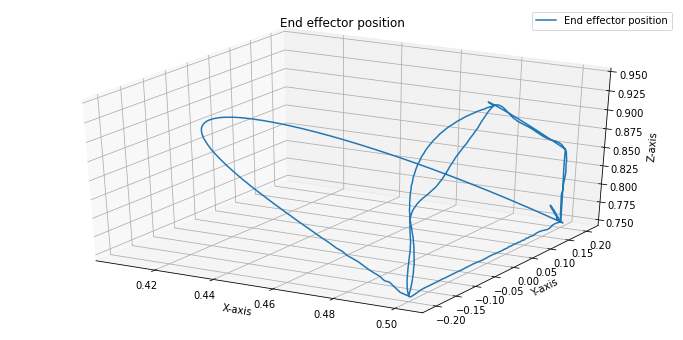

<Figure size 432x288 with 0 Axes>

In [24]:
# Plot joint states
q_p2p = parse_joint_states(p2p_joint_states)
q_hocook = parse_joint_states(ho_cook_joint_states)
plot_qs(q_p2p, q_hocook)


# Plot trajectory for the HoCook
parsed_trajectories = {}
for i, t in enumerate(joint_trajectory['points']): 
    p_, v_, t_ = parse_trajectory(joint_trajectory['points'][i])
    if len(t_) > 0: 
        print("Trajectory {}: {}".format(i, len(t_)))
        t_ = np.linspace(0, max(t_), len(p_))
    parsed_trajectories["{}".format(f"{i}")] = {"p": p_, "v": v_, "t": t_}


t = parsed_trajectories['7']   
plot_pva(t['p'], t['v'], t['t'])

# Plot 3d end effector position
x = current_pose['position.x']
y = current_pose['position.y']
z = current_pose['position.z']

plot_3d(x, y, z)

## TODO: 
- [x] Add plotting of the 3D p2p and hocook motion 
- [x] Add plotting of the joint_states p2p and hocook comparison
- [x] Add plotting of the hocook